In [1]:
import os
import pandas as pd
import tensorflow as tf

In [2]:
def load_data(dir):
    data = list()
    for folder in os.listdir(dir):
        for file in os.listdir(os.path.join(dir, folder)):
            with open(os.path.join(dir, folder, file), 'r', encoding="utf16") as text:
                words = text.read()
                data.append([words, folder])
    df = pd.DataFrame(data, columns = ['text', 'label'])
    return df

In [3]:
df = load_data('./dataset/train')
df_test = load_data('./dataset/test')

In [4]:
df.head()

,text,label
0,"Gặp lại hồn quê Bàn, ghế, đèn... toàn tre làm...",Loi song
1,"Mùa xuân, nói chuyện trường thọ Suốt 5 năm qu...",Loi song
2,Ám ảnh nghề hoại thai Ảnh minh họa Có lần tôi...,Loi song
3,Giúp trẻ vượt qua nỗi sợ hãi Trong độ tuổi từ...,Loi song
4,Không cúi đầu xuống…\nRồi một lần tôi chứng k...,Loi song


<AxesSubplot:xlabel='label'>

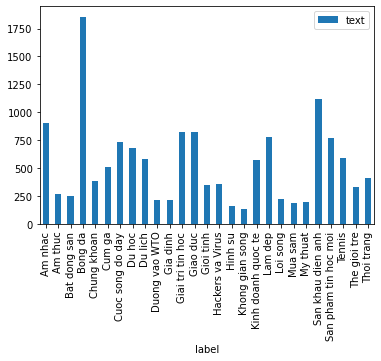

In [5]:
df.groupby('label').count().plot.bar()

<AxesSubplot:xlabel='label'>

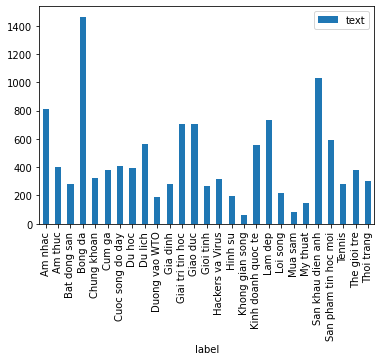

In [6]:
df_test.groupby('label').count().plot.bar()

In [7]:
summaries = df['text'].values

In [8]:
summaries[1][:100]

' Mùa xuân, nói chuyện trường thọ Suốt 5 năm qua, Jerry Friedman - ở Connecticut, Mỹ - đã đi vòng qua'

In [9]:
def no_accent_vietnamese(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

In [10]:
import re
from multiprocessing import Pool

def text_cleaner(summary):
    a_text = no_accent_vietnamese(summary)
    a_text = a_text.lower()
    a_text = a_text.replace('\n', ' ')
    a_text = re.sub(r"[^a-zA-Z0-9 ]","",a_text)
    a_text = re.sub(r'\s+', ' ', a_text).strip()
    return a_text

p = Pool(4)
copus = p.map(text_cleaner, summaries)

In [11]:
copus[1][:100]

'mua xuan noi chuyen truong tho suot 5 nam qua jerry friedman o connecticut my da di vong quanh the g'

In [12]:
label = df['label'].values

In [13]:
vocab_size = 50000
embedding_dim = 100
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [15]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(copus)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'co': 2,
 'cua': 3,
 'va': 4,
 'la': 5,
 'nhung': 6,
 'trong': 7,
 'mot': 8,
 'da': 9,
 'cho': 10}

In [16]:
len(word_index)

57797

In [17]:
X = tokenizer.texts_to_sequences(copus)
X = pad_sequences(X, maxlen=max_length)
print(X.shape)

(14375, 250)


In [18]:
print(label.shape)

(14375,)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42)

In [21]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print(list(label_encoder.classes_), '\n')
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

['Am nhac', 'Am thuc', 'Bat dong san', 'Bong da', 'Chung khoan', 'Cum ga', 'Cuoc song do day', 'Du hoc', 'Du lich', 'Duong vao WTO', 'Gia dinh', 'Giai tri tin hoc', 'Giao duc', 'Gioi tinh', 'Hackers va Virus', 'Hinh su', 'Khong gian song', 'Kinh doanh quoc te', 'Lam dep', 'Loi song', 'Mua sam', 'My thuat', 'San khau dien anh', 'San pham tin hoc moi', 'Tennis', 'The gioi tre', 'Thoi trang'] 



In [22]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(11500, 250) (11500,)
(2875, 250) (2875,)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

num_classes = len(label_encoder.classes_)
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 27)                2727      
Total params: 5,083,127
Trainable params: 5,083,127
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
epochs = 15
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[EarlyStopping(monitor='accuracy', patience=3, min_delta=0.0001)])

Epoch 1/15
180/180 [==============================] - 593s 3s/step - loss: 1.4511 - accuracy: 0.5495
Epoch 2/15
180/180 [==============================] - 621s 3s/step - loss: 1.3927 - accuracy: 0.5723
Epoch 3/15
180/180 [==============================] - 612s 3s/step - loss: 1.3481 - accuracy: 0.5850
Epoch 4/15
180/180 [==============================] - 619s 3s/step - loss: 1.1394 - accuracy: 0.6523
Epoch 5/15
180/180 [==============================] - 628s 3s/step - loss: 1.1776 - accuracy: 0.6486
Epoch 6/15
180/180 [==============================] - 603s 3s/step - loss: 0.9345 - accuracy: 0.7123
Epoch 7/15
180/180 [==============================] - 610s 3s/step - loss: 0.8299 - accuracy: 0.7453
Epoch 8/15
180/180 [==============================] - 611s 3s/step - loss: 0.7251 - accuracy: 0.7738
Epoch 9/15
180/180 [==============================] - 572s 3s/step - loss: 0.7173 - accuracy: 0.7823
Epoch 10/15
180/180 [==============================] - 606s 3s/step - loss: 0.6868 - accura

In [46]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)))

                      precision    recall  f1-score   support

             Am nhac       0.69      0.94      0.80       177
             Am thuc       0.74      0.74      0.74        47
        Bat dong san       0.50      0.45      0.48        42
             Bong da       0.98      0.97      0.98       363
         Chung khoan       0.55      0.90      0.69        69
              Cum ga       0.93      0.91      0.92        89
    Cuoc song do day       0.52      0.39      0.45       146
              Du hoc       0.93      0.54      0.68       142
             Du lich       0.60      0.84      0.70       130
       Duong vao WTO       0.43      0.26      0.33        38
            Gia dinh       0.27      0.26      0.26        35
    Giai tri tin hoc       0.49      0.68      0.57       177
            Giao duc       0.64      0.77      0.70       182
           Gioi tinh       0.50      0.77      0.61        66
    Hackers va Virus       0.67      0.47      0.55        79
       

In [49]:
label_test = label_encoder.transform(df_test['label'])

In [50]:
copus_test = p.map(text_cleaner, df_test['text'].values)

In [51]:
copus_test = tokenizer.texts_to_sequences(copus_test)
copus_test = pad_sequences(copus_test, maxlen=max_length)

In [52]:
label_pred = model.predict(copus_test)
label_pred = np.argmax(label_pred, axis=1)
print(classification_report(label_test, label_pred, target_names=list(label_encoder.classes_)))

                      precision    recall  f1-score   support

             Am nhac       0.64      0.93      0.76       813
             Am thuc       0.89      0.68      0.77       400
        Bat dong san       0.51      0.39      0.44       282
             Bong da       0.98      0.97      0.98      1464
         Chung khoan       0.43      0.86      0.57       320
              Cum ga       0.89      0.93      0.91       381
    Cuoc song do day       0.29      0.28      0.29       405
              Du hoc       0.92      0.40      0.55       394
             Du lich       0.64      0.82      0.72       565
       Duong vao WTO       0.40      0.26      0.32       191
            Gia dinh       0.30      0.16      0.21       280
    Giai tri tin hoc       0.42      0.66      0.51       707
            Giao duc       0.64      0.79      0.71       707
           Gioi tinh       0.40      0.69      0.50       268
    Hackers va Virus       0.63      0.52      0.57       319
       